# 06/06/22 - Running MGE and JAM on J0037 cleanly using functions from script slacs_mge_jampy.py

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from astropy.cosmology import Planck18 as cosmo  # Planck 2018
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel

################################################################
# some needed constants
kcwi_scale = 0.147  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
photometric_zeropoint = 25.745

In [2]:
# specify object directory and name

data_dir = '/home/shawn/data/' # data directory
obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
obj_abbr = obj_name[4:9] # e.g. J0029
file_dir = f'{data_dir}CF_mosaics/{obj_name}/' # directory with all files of obj_name

# First look at the KCWI integrated datacube and HSTF435W image, crop to 3 arcsec

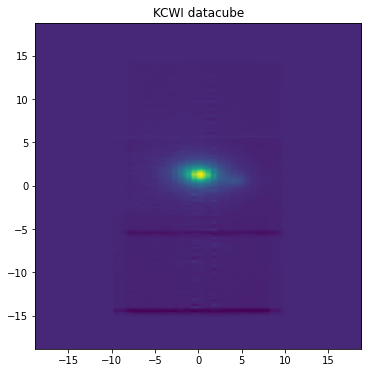

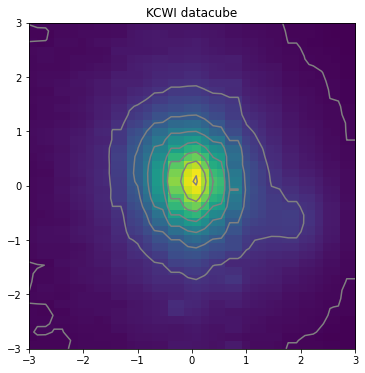

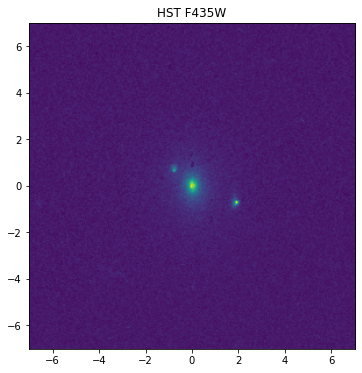

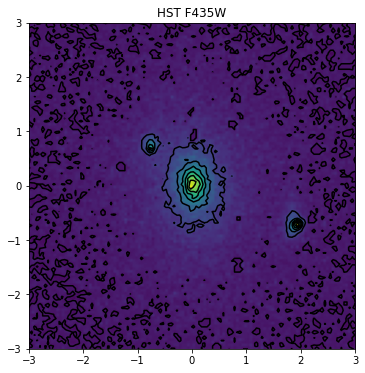

In [3]:
# import image, center, and crop

#######################################################################################
# kcwi datacube

kcwi_img, kcwi_3arc_img, kcwi_header, \
    kcwi_central_pix_x, kcwi_central_pix_y = import_center_crop(file_dir, obj_name, obj_abbr, 
                                                          data_source='kcwi_datacube', plot=True)

#######################################################################################
# F435W cutout

hstF435_img, hstF435_3arc_img, hstF435_header, \
    central_pix_x, central_pix_y = import_center_crop(file_dir, obj_name, obj_abbr, 
                                                      data_source='F435W', plot=True)


# Estimate PSF using Gaussian MGE for each image...

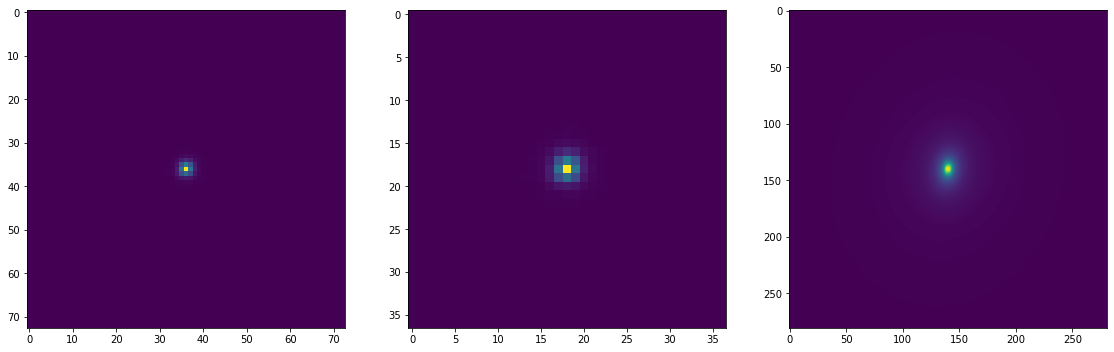

In [4]:
# Let's look at the HST image first
file = f'{file_dir}{obj_name}_F435W.fits'
hdul = fits.open(file)

plt.figure()
plt.tight_layout()

#######################################################################################
# 4th hdu is psf
psf_hdu = hdul[3]
hst_psf_model = psf_hdu.data
hst_psf_header = psf_hdu.header
#print(hst_psf_header) # header is not useful
plt.subplot(131)
plt.imshow(hst_psf_model)

#######################################################################################
# 10th hdu is smaller psf
psf_small_hdu = hdul[9]
hst_psf_small_model = psf_small_hdu.data
hst_psf_small_header = psf_small_hdu.header
#print(psf_header) # header is not useful
plt.subplot(132)
plt.imshow(hst_psf_small_model)


#######################################################################################
# 8th hdu is bspline model
bspline_hdu = hdul[7]
hst_bspline_model = bspline_hdu.data
hst_bspline_header = bspline_hdu.header
#print(bspline_header)
plt.subplot(133)
plt.imshow(hst_bspline_model)
plt.subplots_adjust(bottom=0.1, right=2, top=0.9)
plt.pause(1)


# Fit the PSF model with Gaussian MGE.

In [5]:
# find the right fraction to use

#find_galaxy
#try_fractions_for_find_galaxy(hst_psf_model)

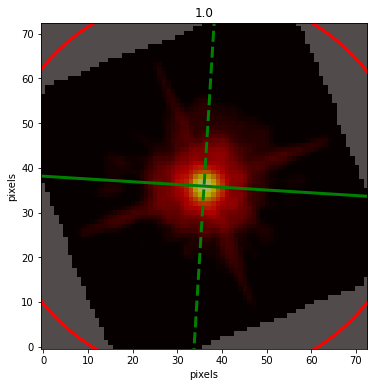

0.05042878760754688 3.5415987526017574


In [6]:
# Just use the whole image.
frac = 1.0
# 

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(hst_psf_model, fraction=frac, plot=1, quiet=True)
eps = f.eps
theta = f.theta
cen_y = f.ypeak
cen_x = f.xpeak
plt.title(f'{frac}')
plt.pause(1)

print(eps, theta)

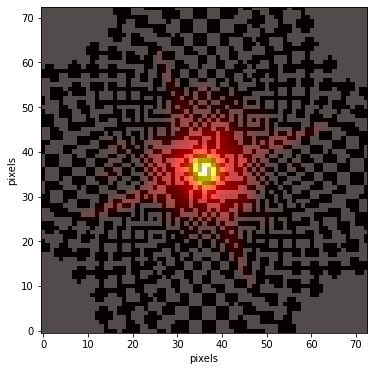

In [7]:
# It's basically circular, but I don't know how to do this as 1D. 
# run sectors photometry
plt.clf()
s = sectors_photometry(hst_psf_model, eps, theta, cen_x, cen_y, plot=1)
plt.pause(1)  # Allow plot to appear on the screen


Iteration:1  chi2: 155.5  Nonzero: 7/12
Nonzero Gaussians: 6/12
Eliminating not useful Gaussians...
ngauss: 5          chi2: 134.2
Starting nonlinear fit...
Iteration:1  chi2: 134.2  Nonzero: 5/5
Nonzero Gaussians: 5/5
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.27 seconds
  Total Iterations:  10
 Nonzero Gaussians:  5
  Unused Gaussians:  7
 Sectors used in the fit:  19
 Total number of points fitted:  424
 Chi2: 134.1 
 STDEV: 0.465 
 MEANABSDEV: 0.4111 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  1.176437e-01     0.380000     0.932621
  5.616214e-01     0.966834     1.000000
  1.850400e-01      1.59761     1.000000
  6.106347e-02      3.22752     0.955569
  7.608733e-02      7.46306     1.000000
++++++++++++++++++++++++++++++++++++++++++++


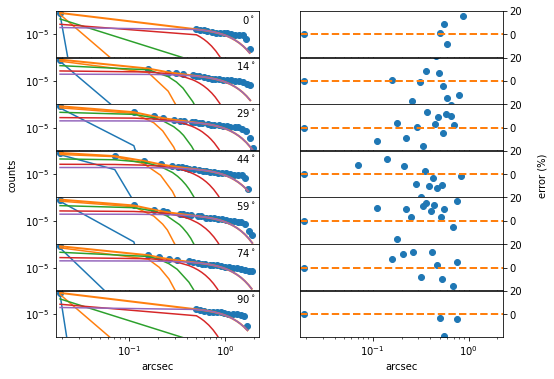

How good is the fit? Should be low (~ 0.02)... 0.4111019369597713


In [8]:
############################################################################################################################

# select number of gaussians to fit

scale = hst_scale
ngauss = 12

###########################################################################
# fit and plot

plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, #sigmapsf=sigmapsf, #normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the output weights and sigmas for each Gaussian

hst_psf_weights = m.sol[0] # unnormalized weights in counts of each Gaussian
hst_normpsf = hst_psf_weights / np.sum(hst_psf_weights) # normalized weights for psf
hst_sigmapsf = m.sol[1] # sigma of each Gaussian

print('How good is the fit? Should be low (~ 0.02)... ' + str(m.absdev))

# Datapoints that drop off sharply at large radii worsen the fit and should be removed as skylevel.


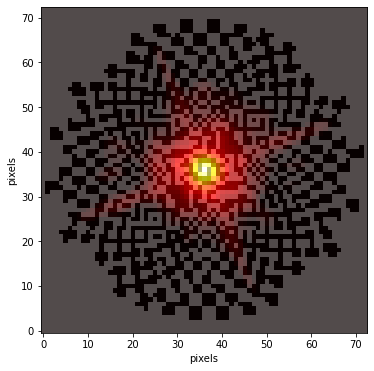

In [9]:
#################################################
# Set the minlevel by eye for this one
minlevel = 2*1e-6

# run sectors photometry
plt.clf()
s = sectors_photometry(hst_psf_model, eps, theta, cen_x, cen_y, minlevel=minlevel, plot=1)
plt.pause(1)  # Allow plot to appear on the screen


Iteration:1  chi2: 12.20  Nonzero: 8/12
Iteration:11  chi2: 11.65  Nonzero: 6/12
Nonzero Gaussians: 6/12
Eliminating not useful Gaussians...
ngauss: 5          chi2: 11.64
Starting nonlinear fit...
Iteration:1  chi2: 11.64  Nonzero: 5/5
Nonzero Gaussians: 5/5
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.28 seconds
  Total Iterations:  15
 Nonzero Gaussians:  5
  Unused Gaussians:  7
 Sectors used in the fit:  19
 Total number of points fitted:  387
 Chi2: 11.62 
 STDEV: 0.1706 
 MEANABSDEV: 0.1303 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  1.219898e-01     0.380000     0.980000
  5.791940e-01     0.976113     1.000000
  1.847795e-01      1.72293     1.000000
  8.123488e-02      4.61518     0.980000
  5.516521e-02      14.2546     0.980000
++++++++++++++++++++++++++++++++++++++++++++


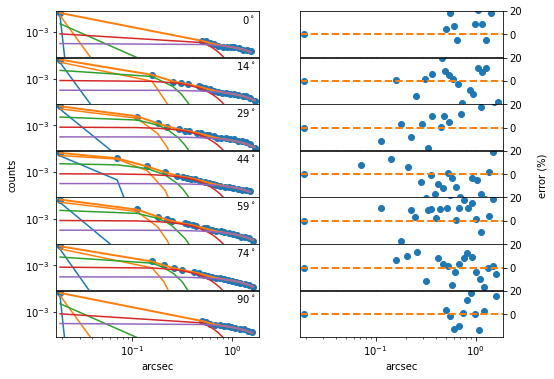

How good is the fit? Should be low (~ 0.02)... 0.1303200854422108


In [10]:
############################################################################################################################
# select number of gaussians to fit (max of 20... penalty in uncertainty)
ngauss = 12

# pixel scale is hst scale
scale = hst_scale

# set qbound to force Gaussians to be nearly circular
qbounds = [0.98, 1.0]


###########################################################################
# fit and plot

plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, qbounds=qbounds,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the output weights and sigmas for each Gaussian

hst_psf_weights = m.sol[0] # unnormalized weights in counts of each Gaussian
hst_normpsf = hst_psf_weights / np.sum(hst_psf_weights) # normalized weights for psf
hst_sigmapsf = m.sol[1] # sigma of each Gaussian

print('How good is the fit? Should be low (~ 0.02)... ' + str(m.absdev))

# What about the KCWI PSF? The notes I took from our meeting are not clear.
___________________________

# Now go ahead and fit the HST image at 3 arcsec

In [11]:
# take 3 arcsec hst image for find_galaxy initial estimates of PA and ellipticity

img = hstF435_3arc_img

############################################################################################################################
# figure out the pixel fraction best to use

#try_fractions_for_find_galaxy(img)

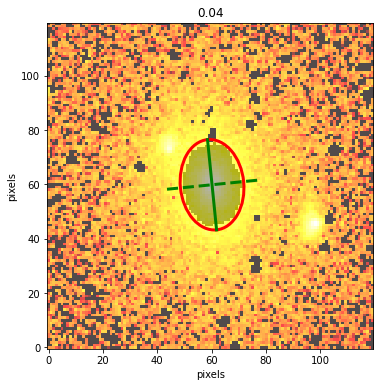

In [13]:
# set the fraction to be used as frac

frac = 0.04

#################################################
# Model the central light ellipse

plt.clf()
#plt.clf()
f = find_galaxy(img, fraction=frac, plot=1, quiet=True)
eps = f.eps
theta = f.theta
cen_y = f.ypeak
cen_x = f.xpeak
plt.title(f'{frac}')
plt.pause(1)


# Get minlevel for this image by taking ~1/2 std of the background


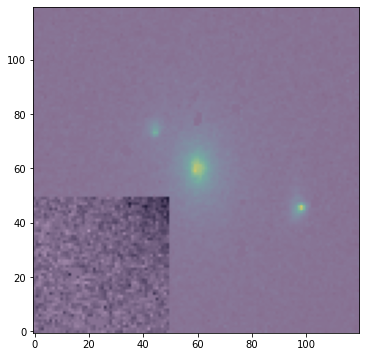

In [14]:
# calculate the minimum level for inclusion in the photometry fitting from the background

size=50
minlevel, noise = calculate_minlevel(img, size)

In [15]:
print(minlevel)

0.007076466293540728


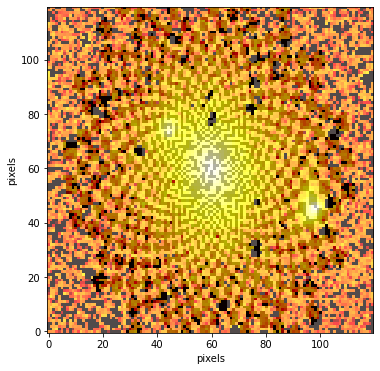

In [16]:
################################################
# Perform galaxy photometry with full image

plt.clf()
s = sectors_photometry(img, eps, theta, cen_x, cen_y, minlevel=minlevel, plot=1)
plt.pause(1)  # Allow plot to appear on the screen

Iteration:1  chi2: 21.44  Nonzero: 6/12
Iteration:11  chi2: 7.600  Nonzero: 7/12
Iteration:21  chi2: 7.430  Nonzero: 7/12
Nonzero Gaussians: 7/12
Eliminating not useful Gaussians...
ngauss: 6          chi2: 7.432
Starting nonlinear fit...
Iteration:1  chi2: 7.432  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 1.16 seconds
  Total Iterations:  25
 Nonzero Gaussians:  6
  Unused Gaussians:  6
 Sectors used in the fit:  19
 Total number of points fitted:  496
 Chi2: 7.43 
 STDEV: 0.1215 
 MEANABSDEV: 0.08722 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  9.238904e-01     0.380000     0.692549
  1.575472e+01      3.29439     0.739303
  3.111699e+01      6.14274     0.645795
  7.288732e+01      12.0297     0.761856
  1.249031e+01      33.2094     0.289728
  2.202044e+02      33.2094     0.919

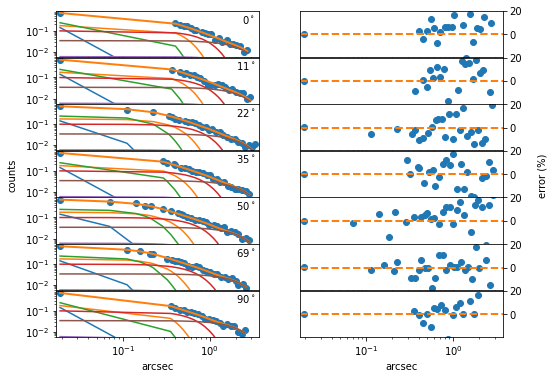

In [17]:
############################################################################################################################

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************

# select number of gaussians to fit
ngauss = 12

# pixel scale
scale = hst_scale

# psf - take from the MGE psf model above
sigmapsf = hst_sigmapsf
normpsf = hst_normpsf
#seeing_fwhm = 0.1 # arcsec
#sigmapsf = seeing_fwhm / scale / 2.355 # pixels, 2.355 is fwhm/sigma

# exposure time
exp_time = hstF435_header['EXPTIME']

###########################################################################
# fit and plot

plt.clf()
m = mge_fit_sectors(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 


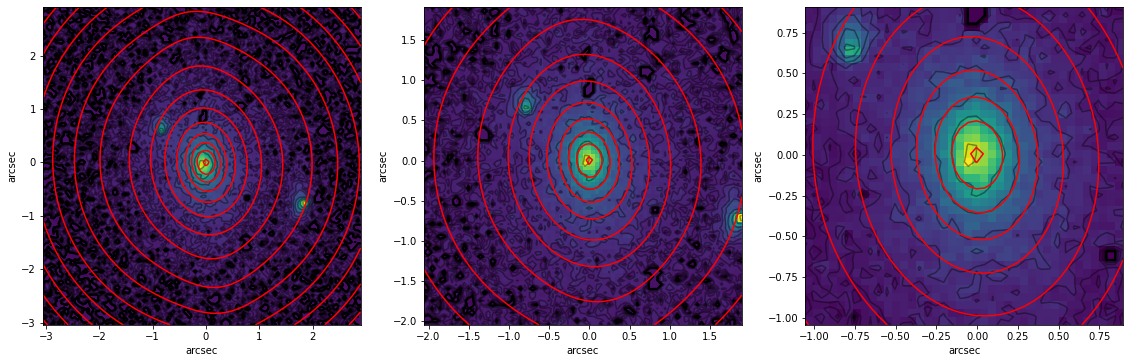

In [18]:
plot_contours_321 (img, f, m, sigmapsf, normpsf, contour_alpha=0.4, data_source='F435W')

--------------------------
# Looks good! Everything from here will have to be done with the mge_fit_sectors_regularized. Just do all the same with _regularized at the end.

Iteration:1  chi2: 21.44  Nonzero: 6/12
Iteration:11  chi2: 7.600  Nonzero: 7/12
Iteration:21  chi2: 7.430  Nonzero: 7/12
Nonzero Gaussians: 7/12
Eliminating not useful Gaussians...
ngauss: 6          chi2: 7.432
Starting nonlinear fit...
Iteration:1  chi2: 7.432  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 1.08 seconds
  Total Iterations:  25
 Nonzero Gaussians:  6
  Unused Gaussians:  6
 Sectors used in the fit:  19
 Total number of points fitted:  496
 Chi2: 7.43 
 STDEV: 0.1215 
 MEANABSDEV: 0.08722 
############################################
  Total_Counts  sigma_Pixels      q_obs
############################################
  9.238904e-01     0.380000     0.692549
  1.575472e+01      3.29439     0.739303
  3.111699e+01      6.14274     0.645795
  7.288732e+01      12.0297     0.761856
  1.249031e+01      33.2094     0.289728
  2.202044e+02      33.2094     0.919

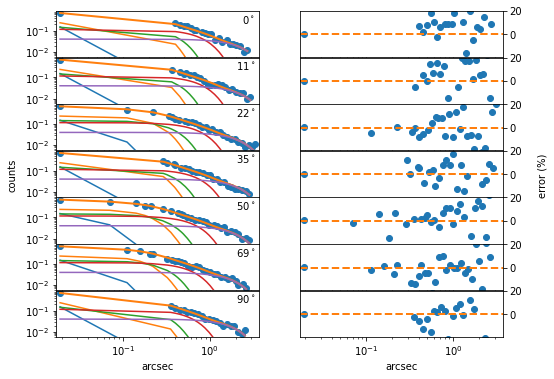

In [21]:
############################################################################################################################

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************

# select number of gaussians to fit
ngauss = 12

# pixel scale
scale = hst_scale

# psf - take from the MGE psf model above
sigmapsf = hst_sigmapsf
normpsf = hst_normpsf
#seeing_fwhm = 0.1 # arcsec
#sigmapsf = seeing_fwhm / scale / 2.355 # pixels, 2.355 is fwhm/sigma

# exposure time
exp_time = hstF435_header['EXPTIME']

###########################################################################
# fit and plot

plt.clf()
m = mge_fit_sectors_regularized(s.radius, s.angle, s.counts, eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.pause(1) 

#############################################################################
# take the outputs and convert to the needed units

# convert sigma from pixels to arcsec and surface brightness to surface density
sigma, surf_density, q = convert_mge_model_outputs (m, exp_time, extinction, photometric_zeropoint, data_source='F435W')


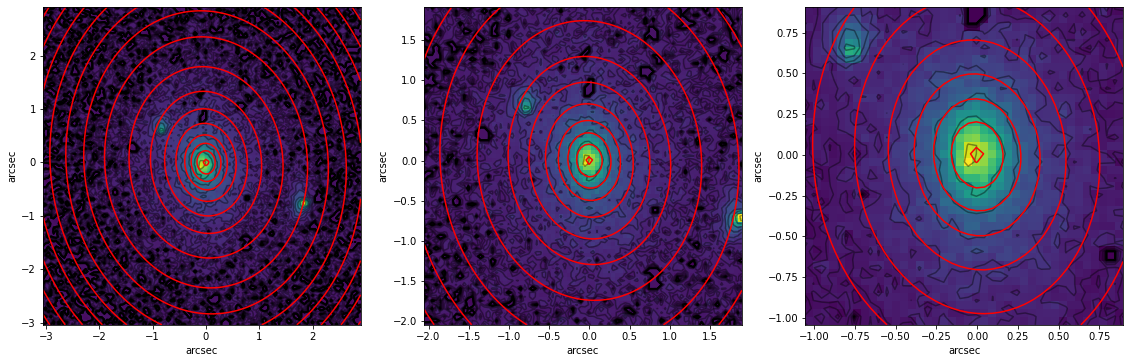

In [22]:
plot_contours_321 (img, f, m, sigmapsf, normpsf, contour_alpha=0.4, data_source='F435W')

# Need to get effective (half-light) radius from this... i.e. radius at which half the total light is enclosed. So... That will be where half the sum of the total counts of the Gaussian components are enclosed.

In [23]:
# take values from the mge expansion
lum_ks = m.sol[0]
lum_tot = np.sum(lum_ks) # total lumninosity is sum of the components
sigma_ks = m.sol[1] * hst_scale
q_ks = m.sol[2]

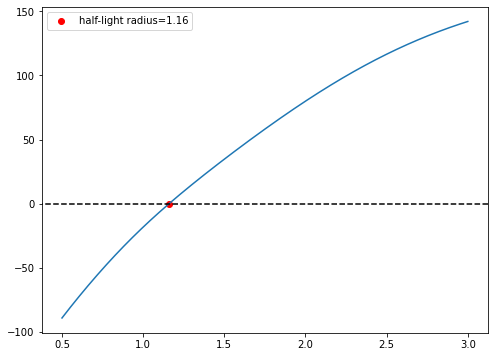

In [24]:
half_light_radius = find_half_light(lum_ks, sigma_ks, q_ks)

# Michele has a routine to calculate the half light radius... I don't know why it wasn't showing up in my directory... :(

In [25]:
from jampy.mge_half_light_isophote import mge_half_light_isophote

half_light_radius_mich, _, _, _ = mge_half_light_isophote(surf_density, sigma, q)
print( (half_light_radius - half_light_radius_mich) / half_light_radius_mich)

-0.0002151210009278633


# Okay, so my estimate is within 0.02% of Michele's

___________________

# Look at kinematics.



In [26]:
from plotbin.sauron_colormap import register_sauron_colormap

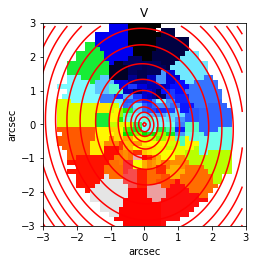

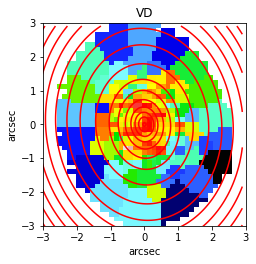

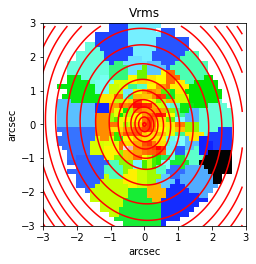

In [27]:
V, VD, Vrms, dV, dVD, dVrms, Vbary, center_axis_index = load_2d_kinematics (file_dir, obj_name, img, f, m, sigmapsf, normpsf, contour_alpha=0.0, data_source='F435W', plot=True, plot_img=False)

# This is pretty, but we need it by bins, not by pixel.

In [28]:
V_bin, VD_bin, Vrms_bin, dV_bin, dVD_bin, dVrms_bin, xbin_arcsec, ybin_arcsec = bin_velocity_maps (file_dir, obj_abbr, Vbary, center_axis_index, data_source='KCWI')

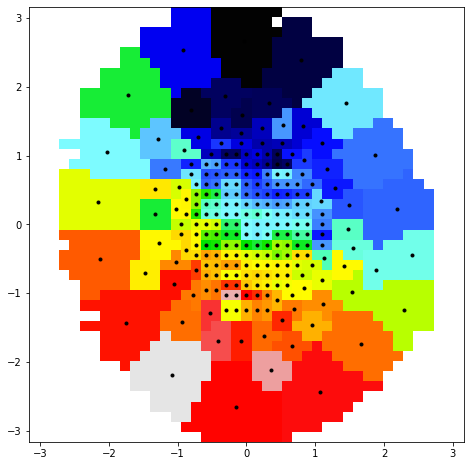

In [29]:
# Check binning

# plot with arcsec
width =  V.shape[0]/2 * kcwi_scale
extent = [-width,width,-width,width]
plt.figure(figsize=(8,8))
plt.imshow(V, origin='lower', extent=extent, cmap='sauron')
plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')

# Determine correction to intrinsic (barycenter) velocity and kinematics PA with PAFit.

In [30]:
from pafit.fit_kinematic_pa import fit_kinematic_pa

  Kin PA: 158.5  +/-  10.2  (3*sigma error)
Velocity Offset: 8.84


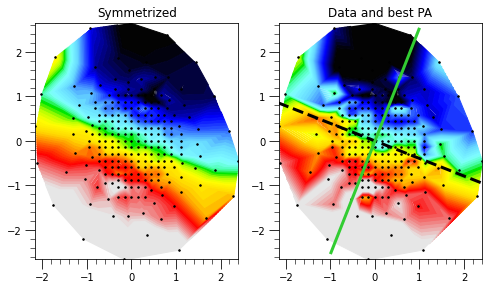

In [31]:
PA_kin, dPA_kin, velocity_offset = fit_kinematic_pa(xbin_arcsec, ybin_arcsec, V_bin)

In [32]:
# Vbary_new = Vbary+correction
# V_new = V - correction
V_bin = V_bin - velocity_offset

# set kinematic PA from the negative x-axis
PA_kin = 270 - PA_kin

# PA_phot is theta from find_galaxy, measure from negative x-axis
PA_phot = theta

In [33]:
# Whoa, these are very different
print(PA_kin) # PA from kinematics
print(f.theta) # PA from photometry

111.5
84.27748713543393


  Kin PA:  90.0  +/-   9.5  (3*sigma error)
Velocity Offset: 0.00


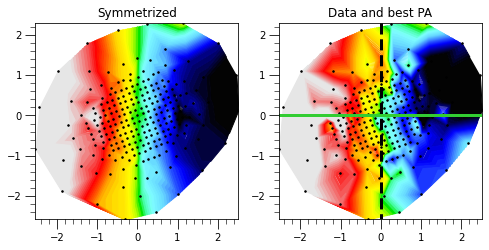

In [34]:
# rotate the bins by the PA from photomety # No, we should use the kinematics PA
# plot the rotation with the "non-symmetrized velocity field"

xbin, ybin = rotate_bins (PA_kin+180, xbin_arcsec, ybin_arcsec, V_bin, plot=True)

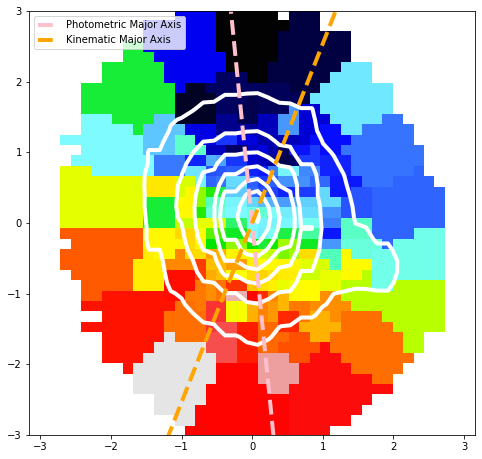

In [35]:
# Look at photometric and kinematic major axis offsets

# plot with arcsec
width =  V.shape[0]/2 * kcwi_scale
extent = [-width,width,-width,width]
plt.figure(figsize=(8,8))
plt.imshow(V, origin='lower', extent=extent, cmap='sauron')
#plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')
plt.contour(kcwi_3arc_img,
            extent=[-3,3,-3,3],
            linewidths=4,
            colors='white')

# plot the major axes
# photometric
x = np.linspace(-3, 3, 1000)
yph = -np.tan(np.radians(PA_phot))*x
plt.plot(x,yph, 
         label='Photometric Major Axis', 
         c='pink',
        linestyle='--',
        linewidth=4)
# kinematic
ykin = -np.tan(np.radians(PA_kin))*x
plt.plot(x,ykin, 
         label='Kinematic Major Axis', 
         c='orange',
        linestyle='--',
        linewidth=4)

plt.ylim(-3,3)
plt.legend()

______________________

# First try JAM with constant anisotropy (without radial dependece)

In [36]:
#############################################################
# JAM Parameters

##############################################################################

'''
What do I do for inclination?
'''
inc = 80 #np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

'''
beta
'''
# constant beta - Do opsikov-merritt later
beta = np.full_like(surf, 0.2)

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

'''
What do I do for black hole mass? - According to CF, he thinks it probably doesn't matter
'''
mbh = 0# 1e8 # Black hole mass in solar masses # not sure what to do here

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs

'''
PSF is wrong, should be done with MGE
'''
# kinematics sigmapsf
seeing_fwhm = 1.0 # arcsec, typical of KCWI small slicer https://www2.keck.hawaii.edu/inst/kcwi/configurations.html
# pixel scale
sigmapsf = seeing_fwhm / 2.355

#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = kcwi_scale #0.8
goodbins = None


####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.26
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=2.82e+04; BH=0.0; chi2/DOF=1.89
Total mass MGE (MSun): 4.783e+11


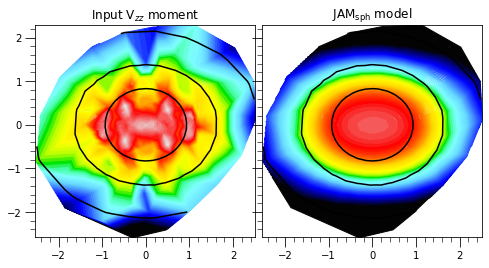

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.18
inc=80.0; beta[0]=0.20; kappa=-152.; M/L=1.00; BH=0.0; chi2/DOF=2.15
Total mass MGE (MSun): 1.696e+07


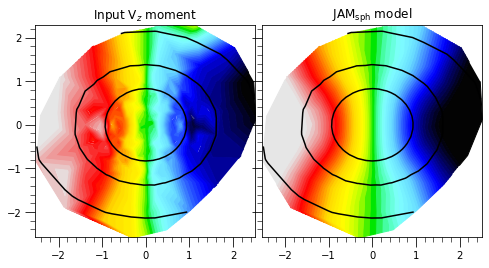

<Figure size 576x432 with 0 Axes>

In [37]:

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     #flux_obs=flux_obs,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2


# JAM-time! Start with assigning beta_k to each Gaussian with Osipkov-Merritt profile

$$Beta(r) = \frac{r^2}{r_{ani}^2 + r^)} = \frac{1}{a_{ani}^2 (r_{eff}/r)^2 + 1}$$
$$a_{ani} = r_{ani} / r_{eff}$$

For r << r_ani, Beta ~ 0
For r >> r_ani, Beta ~ 1


Text(0.5, 1.0, 'Osipkov-Merritt Model - $r_{eff}=$1.16')

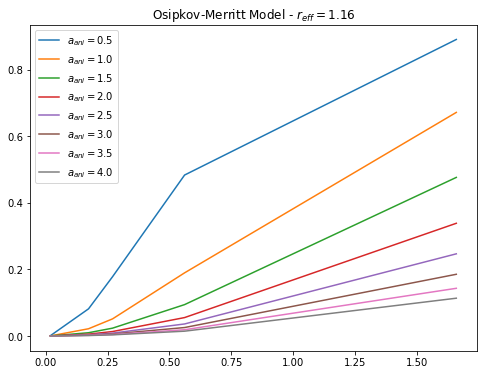

In [38]:
# take a range of values for a_ani (from TDCOSMO IV something between 1-4, likely around 1.5)
a_ani = np.arange(0.5, 4.5, 0.5)

# take half-light radius from MGE
#r_eff_V = 2.68 # arcsec
r_eff = half_light_radius

# take the sigma values for each Gaussian k for R
R = sigma # arcsec

# create array of Beta values for each Gaussian k
Beta = np.zeros(len(R))


for a_ani in a_ani:
    
    for i in range(len(R)):
        r = R[i]
        Beta[i] = osipkov_merritt_model(r, a_ani, r_eff)
        
    #plt.clf()
    plt.plot(R, Beta, label=r'$a_{ani}=$'+str(a_ani))

plt.legend()
plt.title('Osipkov-Merritt Model - ' r'$r_{eff}=$'+f'{np.around(r_eff,3)}') 
    #plt.pause(1)

# Let's take a_ani = 1.5 for now

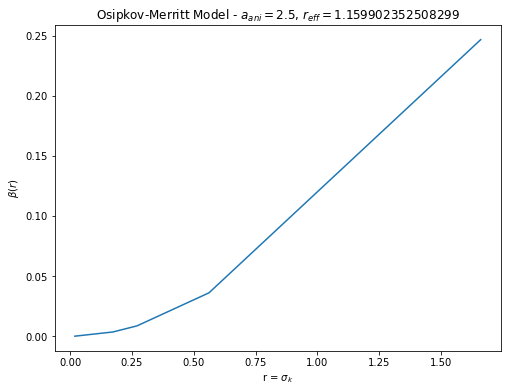

In [185]:
# try different beta # TBD
#beta_list = [0.1,0.2,0.3,0.4,0.5]
#beta = np.full_like(surf, 0.2)

# anisotropy ratio 1.5
a_ani = 2.5

# take the V-band effective radius? What should I actually do?
#r_eff_V = 2.68 # arcsec
r_eff = half_light_radius

# take the sigma values for each Gaussian k for R
sigma # arcsec

# create array of Beta values for each Gaussian k
beta = np.zeros(len(sigma))

# calculate Beta at each sigma
for i in range(len(sigma)):
        r = sigma[i]
        beta[i] = osipkov_merritt_model(r, a_ani, r_eff)
        
plt.clf()
plt.plot(sigma, beta)
plt.xlabel(r'r = $\sigma_k$')
plt.ylabel(r'$\beta(r)$')
plt.title('Osipkov-Merritt Model - '+r'$a_{ani}=$'+f'{a_ani}, '+r'$r_{eff}=$'+f'{r_eff}') 
plt.pause(1)

In [186]:
#############################################################
# JAM Parameters

##############################################################################


'''
What do I do for inclination?
'''
inc = 80 #np.arange(30,95,10)          # Assumed galaxy inclination
        
# take the surface density, etc from mge
surf = surf_density
sigma = sigma
qObs = q

# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

'''
What do I do for black hole mass? - According to CF, he thinks it probably doesn't matter
'''
mbh = 0# 1e8 # Black hole mass in solar masses # not sure what to do here

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs

'''
PSF is wrong, should be done with MGE
'''
# kinematics sigmapsf
seeing_fwhm = 1.0 # arcsec, typical of KCWI small slicer https://www2.keck.hawaii.edu/inst/kcwi/configurations.html
# pixel scale
sigmapsf = seeing_fwhm / 2.355

#normpsf = [0.7, 0.3]
'''
Is pixsize just the pixel scale?
'''
pixsize = kcwi_scale #0.8
goodbins = None


####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 2.78
inc=80.0; beta[0]=4.3e-05; kappa=1.00; M/L=649.; BH=0.0; chi2/DOF=1.96
Total mass MGE (MSun): 4.760e+11


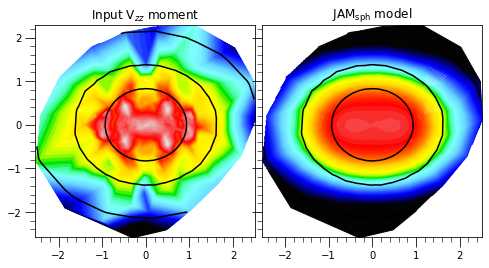

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 2.75
inc=80.0; beta[0]=4.3e-05; kappa=-22.3; M/L=1.00; BH=0.0; chi2/DOF=2.34
Total mass MGE (MSun): 7.330e+08


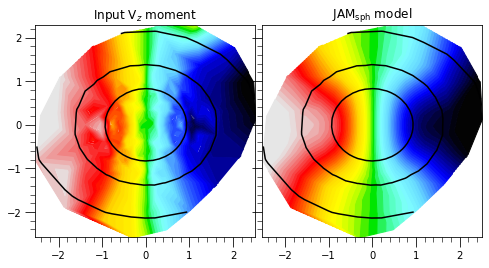

<Figure size 576x432 with 0 Axes>

In [187]:

#############################################################
# It's time to JAM now!

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):
    
    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin, ybin, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)
    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2
